### Data format

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os


%matplotlib inline

In [2]:
base_path = './DataScience2019_MRI/'

behaviour_path = 'Behavioral/cleaned'
behaviour_file = 'HBNFinalSummaries.csv'

In [3]:
behaviour_data = pd.read_csv(os.path.join(base_path, behaviour_path, behaviour_file), low_memory=False)

In [4]:
print(behaviour_data.shape)

(2096, 399)


A total of 2096 subjects are provided with a total of 399 feature columns. From those around 150 features regard the diagnosis given (15 for each of the 10 diagnosis).

We now filter out subjects that have no diagnosis given (incomplete evaluation)

In [5]:
behaviour_data = behaviour_data[behaviour_data['NoDX'].isin(['Yes', 'No'])]
behaviour_data = behaviour_data.reset_index(drop=True)

In [6]:
behaviour_data['DX_01_Cat'].value_counts()

Neurodevelopmental Disorders                                  1167
No Diagnosis Given                                             235
Anxiety Disorders                                              189
Depressive Disorders                                            94
Disruptive                                                      40
Trauma and Stressor Related Disorders                           35
Obsessive Compulsive and Related Disorders                      16
Elimination Disorders                                           11
Other Conditions That May Be a Focus of Clinical Attention       8
Bipolar and Related Disorders                                    6
Disruptive, Impulse Control and Conduct Disorders                5
Schizophrenia Spectrum and other Psychotic Disorders             3
Neurocognitive Disorders                                         3
Gender Dysphoria                                                 1
Substance Related and Addictive Disorders                     

We could also get rid of disorder categories that can be found less than a $threshold$ amount of times. We perform this taking into acount all possible diagnosis for each subject and not only the first one (DX_01_Cat).

In [7]:
threshold = 10

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)]

disorders_all = behaviour_data[category_columns].values.flatten()
disorders_all = disorders_all[np.array(disorders_all, dtype=np.str) != 'nan']

unique, counts = np.unique(disorders_all, return_counts=True)

most_common_disorders = []
for un, c in zip(unique, counts):
    if c >= threshold:
        most_common_disorders.append(un)
        print('{0: <60} found {1} times'.format(un, c))

Anxiety Disorders                                            found 596 times
Bipolar and Related Disorders                                found 10 times
Depressive Disorders                                         found 179 times
Disruptive                                                   found 240 times
Disruptive, Impulse Control and Conduct Disorders            found 35 times
Elimination Disorders                                        found 96 times
Feeding and Eating Disorders                                 found 10 times
Neurodevelopmental Disorders                                 found 2081 times
No Diagnosis Given                                           found 235 times
Obsessive Compulsive and Related Disorders                   found 74 times
Other Conditions That May Be a Focus of Clinical Attention   found 23 times
Schizophrenia Spectrum and other Psychotic Disorders         found 10 times
Trauma and Stressor Related Disorders                        found 77 times


We now create for each individual features concerning these diagnosis disregarding all other information about the diagnosis

In [8]:
classes = np.zeros((len(most_common_disorders), behaviour_data.shape[0]), dtype=np.int32)
df_disorders = behaviour_data[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
            applymap(lambda x: disorder in x if pd.notnull(x) else False)
    
    disorder_df = df_disorders[mask.any(axis=1)]
    
    np.add.at(classes[i], disorder_df.index.values, 1)

Now we can safelly remove previous diagnoses

In [9]:
behaviour_data_columns = behaviour_data.columns.values.astype(np.str)

columns_to_drop = behaviour_data_columns[
    np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX')!=-1)]

behaviour_data = behaviour_data.drop(columns=columns_to_drop)

In [10]:
for disorder, classification in zip(most_common_disorders, classes):
    behaviour_data[disorder] = classification

In [11]:
behaviour_data.shape

(1814, 261)

Now we can continue to remove columns that have a high percentage of Nan

In [12]:
threshold = 0.2

columns_mask = pd.isnull(behaviour_data).sum() / behaviour_data.shape[0] > threshold

behaviour_data = behaviour_data.drop(columns=behaviour_data.columns[columns_mask])

In [13]:
behaviour_data.columns

Index(['Anonymized.ID', 'EID', 'Sex', 'Age', 'Study.Site', 'APQ_P_OPD',
       'APQ_P_Total', 'APQ_SR_OPD', 'APQ_SR_Total', 'ARI_P_Total_Score',
       'ARI_S_Total_Score', 'ASSQ_Total', 'Barratt_Total_Edu',
       'Barratt_Total_Occ', 'Barratt_Total', 'CBCL_AD', 'CBCL_WD', 'CBCL_SC',
       'CBCL_RBB', 'CBCL_AB', 'CBCL_Int', 'CBCL_Ext', 'CBCL_C', 'CBCL_Total',
       'CELF_Total', 'CTOPP_EL_R', 'CTOPP_BW_R', 'CTOPP_NR_R', 'CTOPP_RD_R',
       'CTOPP_RL_R', 'CTOPP_RSN_Comp', 'DTS_absorption', 'DTS_appraisal',
       'DTS_regulation', 'DTS_tolerance', 'DTS_total', 'EHQ_Total',
       'ICU_P_Callous', 'ICU_P_Uncaring', 'ICU_P_Unemotional', 'ICU_P_Total',
       'NLES_P_TotalEvents', 'NLES_P_Upset_Total', 'PCIAT_Total', 'mdx',
       'SCARED_P_GD', 'SCARED_P_PN', 'SCARED_P_SC', 'SCARED_P_SH',
       'SCARED_P_SP', 'SCARED_P_Total', 'SCQ_Total', 'SRS_AWR', 'SRS_COG',
       'SRS_COM', 'SRS_DSMRRB', 'SRS_MOT', 'SRS_RRB', 'SRS_SCI', 'SRS_Total',
       'WIAT_Num_Raw', 'WIAT_Pseudo_Raw', 'WIA

Statistics

An important factor is the distribution of age in the dataset, as a different age allows different questionnaires to be filled.

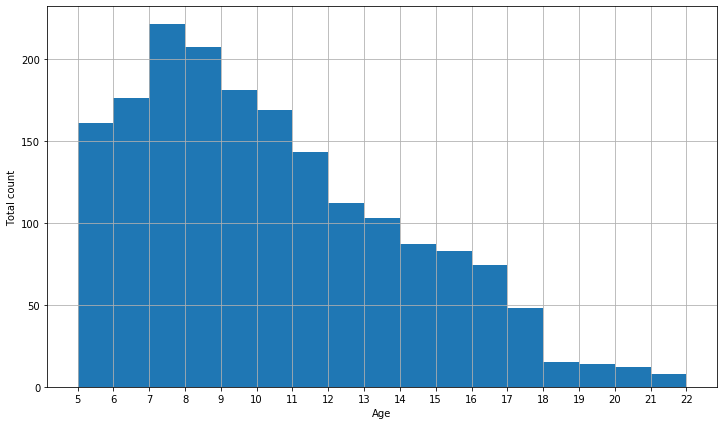

In [14]:
bins = list(range(math.floor(behaviour_data['Age'].min()), math.ceil(behaviour_data['Age'].max() + 1)))

fig = plt.gcf()
fig.set_size_inches(12, 7)
ax = behaviour_data['Age'].hist(bins = bins)
ax.set_xticks(bins)
ax.set_xlabel('Age')
ax.set_ylabel('Total count')

plt.show()

- A recommended streategy would be to use only specific ages (for instance ages 8-16)
- We could also create age bins as a new feature instead of age categories
- Age in every case plays a significant role for the interpretation of the tests and the final results